<a href="https://colab.research.google.com/github/xMatuszek/object_detection_model_using_thermal_camera_dataset/blob/main/object_detection_model_using_thermal_camera_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Dataset

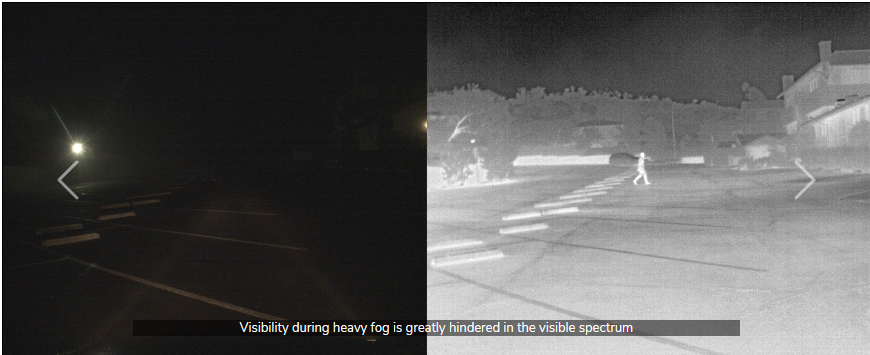


*   Data is organized by **three splits**: training images `("train")`, validation images `("val")`, and validation video `("val_video")`.

*   A total of 9,711 thermal and 9,233 RGB training/validation images are included with a **90%/10% train/val** split



## Labels:
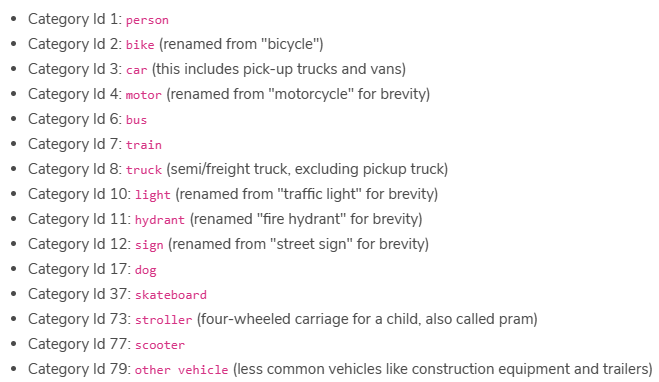







### Thermal Image Annotations
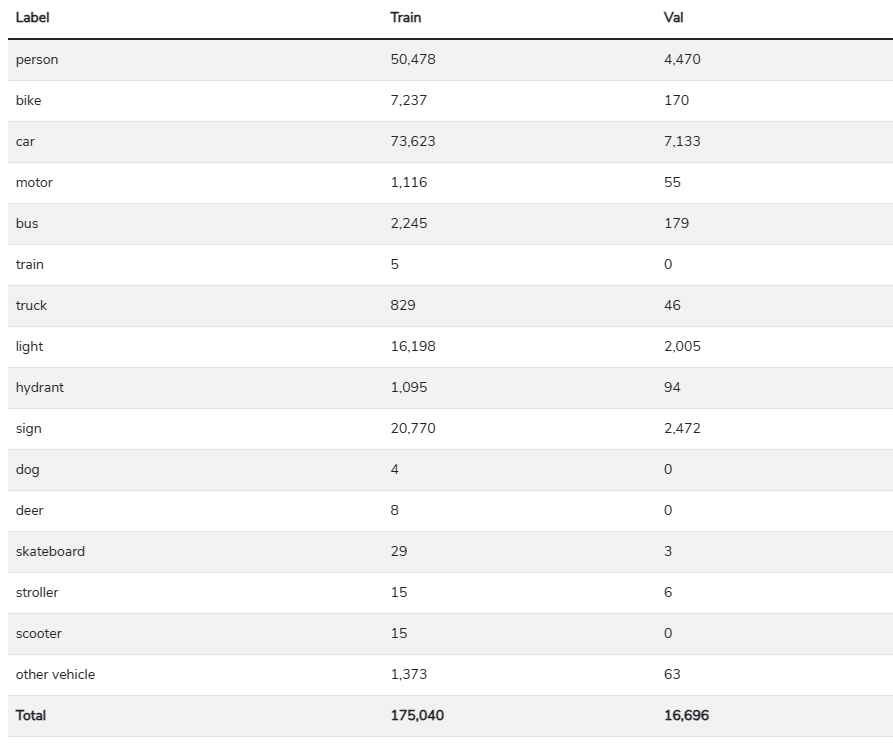

### Visible Image Annotations
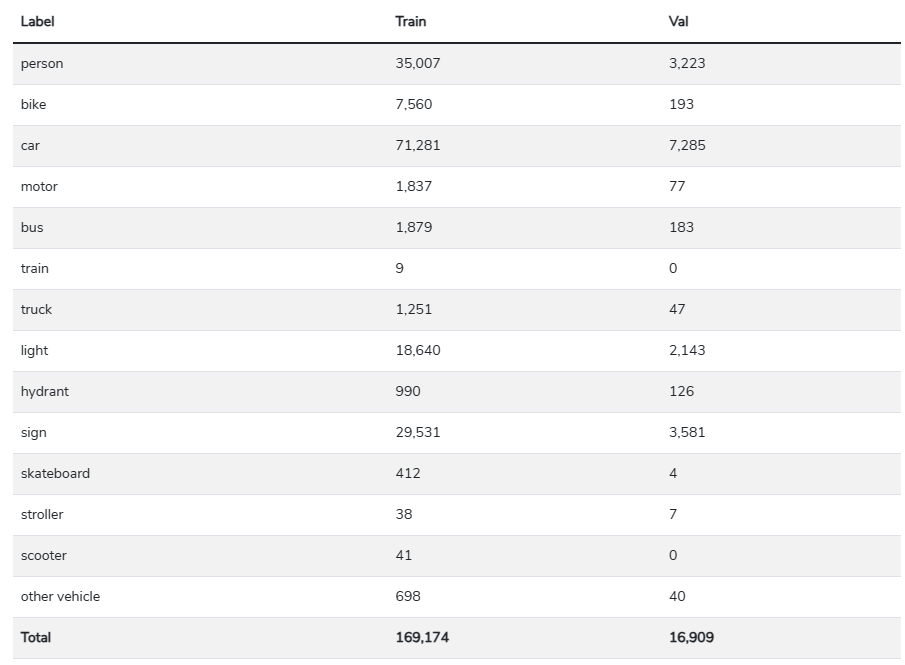

# Ręczna wizualizacja przykładowych danych

Przykładowy obraz z katalogu treningowego **`RGB`**

In [ ]:
import os as os
dataset_location = '/content/drive/MyDrive/AGH/ThermalCameraObjectDetection/data set'

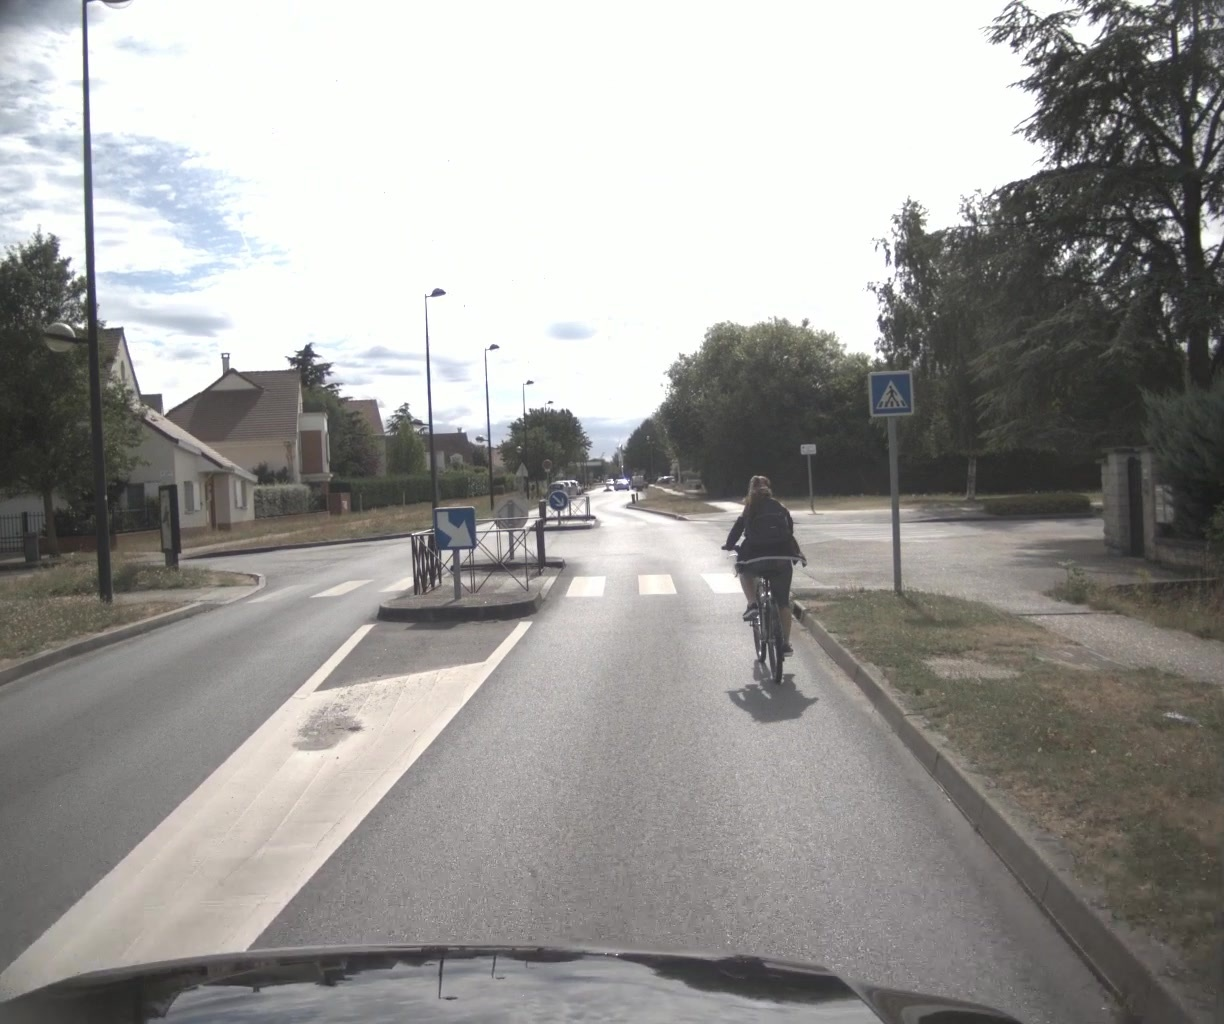

In [ ]:
from IPython.display import Image
import os as os

rgb_images = os.path.join(dataset_location, 'images_rgb_train/data')
first_rgb_image = os.listdir(rgb_images)

Image(filename=f"{rgb_images}/{first_rgb_image[0]}", width=1000)

Przykładowy obraz z katalogu treningowego **`THERMAL`**

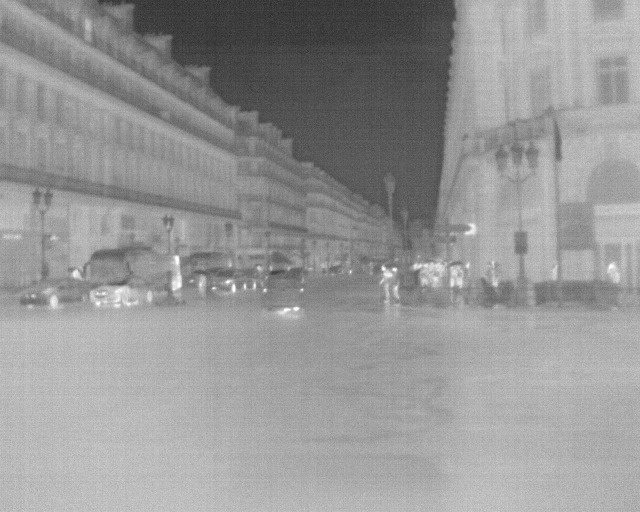

In [ ]:
from IPython.display import Image

thermal_images = os.path.join(dataset_location, 'images_thermal_train/data')
first_thermal_image = os.listdir(thermal_images)

Image(filename=f"{thermal_images}/{first_thermal_image[0]}", width=1000)

# Wizualizacja przykładowych danych z użyciem `PYCOCOTOOLS`

Importujemy potrzebne biblioteki:

In [ ]:
import os
os.chdir('/content')
HOME = os.getcwd()
print(HOME)

os.chdir(f'/content/drive/MyDrive/ob_thermal_camera/data set')
dataset_location = os.getcwd()
print(dataset_location)

/content


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/ob_thermal_camera/data set'

In [ ]:
!pip install pycocotools
import pandas as pd
import os
from pycocotools.coco import COCO
import skimage.io as io
import matplotlib.pyplot as plt
from pathlib import Path

In [ ]:
dataDir=Path(f'{dataset_location}/images_rgb_train')
annFile = Path(f'{dataset_location}/images_rgb_train/coco.json')
coco = COCO(annFile)
imgIds = coco.getImgIds()
imgs = coco.loadImgs(imgIds[-3:])

loading annotations into memory...
Done (t=1.73s)
creating index...
index created!


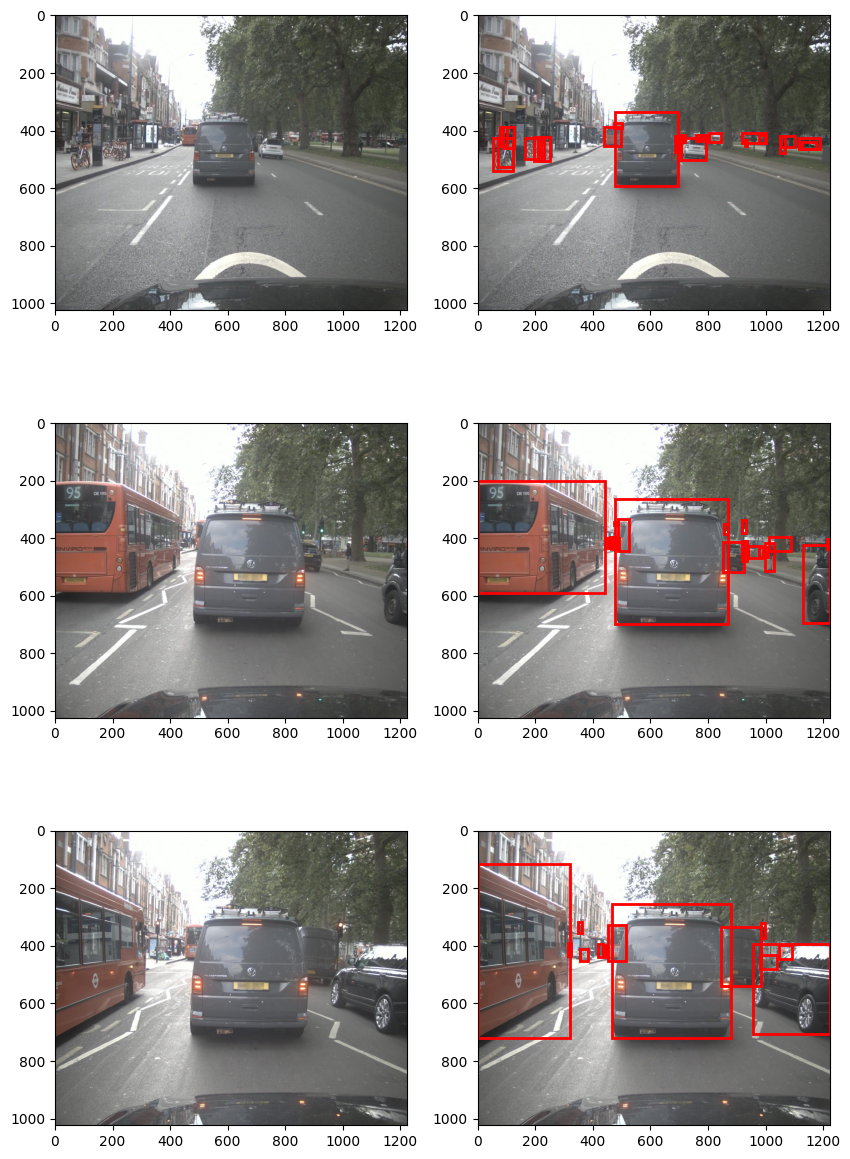

In [ ]:
import matplotlib.patches as patches

imgs = coco.loadImgs(imgIds[-3:])
_,axs = plt.subplots(len(imgs),2,figsize=(10,5 * len(imgs)))
for img, ax in zip(imgs, axs):
  I = io.imread(dataDir / img['file_name'])
  annIds = coco.getAnnIds(imgIds=[img['id']])
  anns = coco.loadAnns(annIds)
  ax[0].imshow(I)
  ax[1].imshow(I)

  # Loop through annotations and draw rectangles
  for ann in anns:
    bbox = ann['bbox']  # Get bounding box coordinates
    x_min, y_min, width, height = bbox
    rectangle = patches.Rectangle(xy=(x_min, y_min),
                                 width=width, height=height,
                                 linewidth=2, edgecolor='r', facecolor='none')  # Red border, no fill
    ax[1].add_patch(rectangle)

plt.show()


# Konwersja COCO na YOLO

### ***COCO*** format:

dataset_subfolder:

**→ data** (zawiera wszystkie obrazy)

*   image1.jpg
*   ...


**→ coco.json** (zawiera adnotacje dla wszystkich obrazów)

**→ coco_annotation_counts.tsv** (zliczenie ilości danych klas w formaxie tsv)

**→ coco_annotation_counts.txt** (zliczenie ilości danych klas w formaxie tsv)

**→ index.json**


### ***YOLO*** format:
dataset_subfolder:

**→ data** (zawiera wszystkie obrazy)

**→ labels** (zawiera wszystkie etykiety)

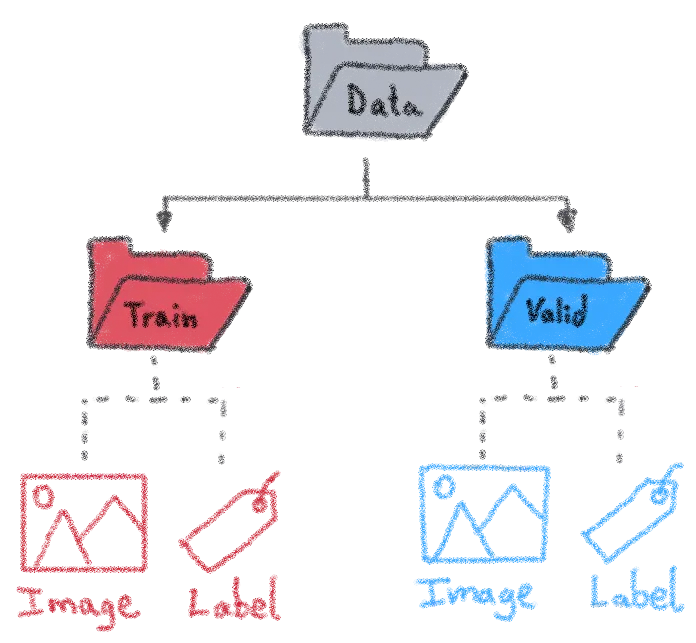

# Tworzymy model YOLOv9 na własnym datasecie

### Pobieramy yolov9

In [1]:
!git clone https://github.com/WongKinYiu/yolov9
%cd yolov9
!pip3 install -r requirements.txt -q

Cloning into 'yolov9'...
remote: Enumerating objects: 668, done.
remote: Counting objects: 100% (294/294), done.
remote: Compressing objects: 100% (93/93), done.
remote: Total 668 (delta 224), reused 201 (delta 201), pack-reused 374
Receiving objects: 100% (668/668), 3.22 MiB | 45.84 MiB/s, done.
Resolving deltas: 100% (269/269), done.
/content/yolov9
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 30.1 MB/s eta 0:00:00


### Importujemy baze z roboflow

In [1]:
%cd /content/yolov9
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="mevN1XAw3kbmgOQLHUZD")
project = rf.workspace("thermalobjectdetectionmodel").project("thermal_object_detection_modell")
version = project.version(1)
dataset = version.download("yolov9")

/content/yolov9
loading Roboflow workspace...
loading Roboflow project...


### Przypisanie zmiennych
Przypisujemy katalogi `HOME` oraz `dataset_location`, które wskazują odpowiednio na katalog główny oraz katalog z datasetem w celu ułatwienia dalszych operacji

In [2]:
import os
os.chdir('/content')
HOME = os.getcwd()
print(HOME)

os.chdir(f'/content/yolov9/thermal_object_detection_modell-1')
dataset_location = os.getcwd()
print(dataset_location)

/content
/content/yolov9/thermal_object_detection_modell-1


### Pobieramy wagi dla modelu

In [3]:
!mkdir -p /content/weights
!wget -P /content/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/gelan-c.pt

### Trenujemy nasz model

In [ ]:
!chmod +w /content/yolov9/thermal_object_detection_model-2/train/labels.cache

In [4]:
%cd /content/yolov9
!python train.py \
--batch 16 --epochs 10 --img 640  --device 0 --min-items 0 --close-mosaic 15 \
--data {dataset_location}/data.yaml \
--weights {HOME}/weights/gelan-c.pt \
--cfg models/detect/gelan-c.yaml \
--hyp hyp.scratch-high.yaml

/content/yolov9
2024-05-21 14:29:13.782949: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-21 14:29:13.783002: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-21 14:29:13.785035: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-21 14:29:14.839190: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
train: weights=/content/weights/gelan-c.pt, cfg=models/detect/gelan-c.yaml, data=/content/yolov9/thermal_object_detection_modell-1/data.yaml, hyp=hyp.scratch-high.yaml, epochs=10, batch_size=16, imgsz=640, rect=False, resume=

### Wyświetlamy wykresy na zbiorze uczącycm

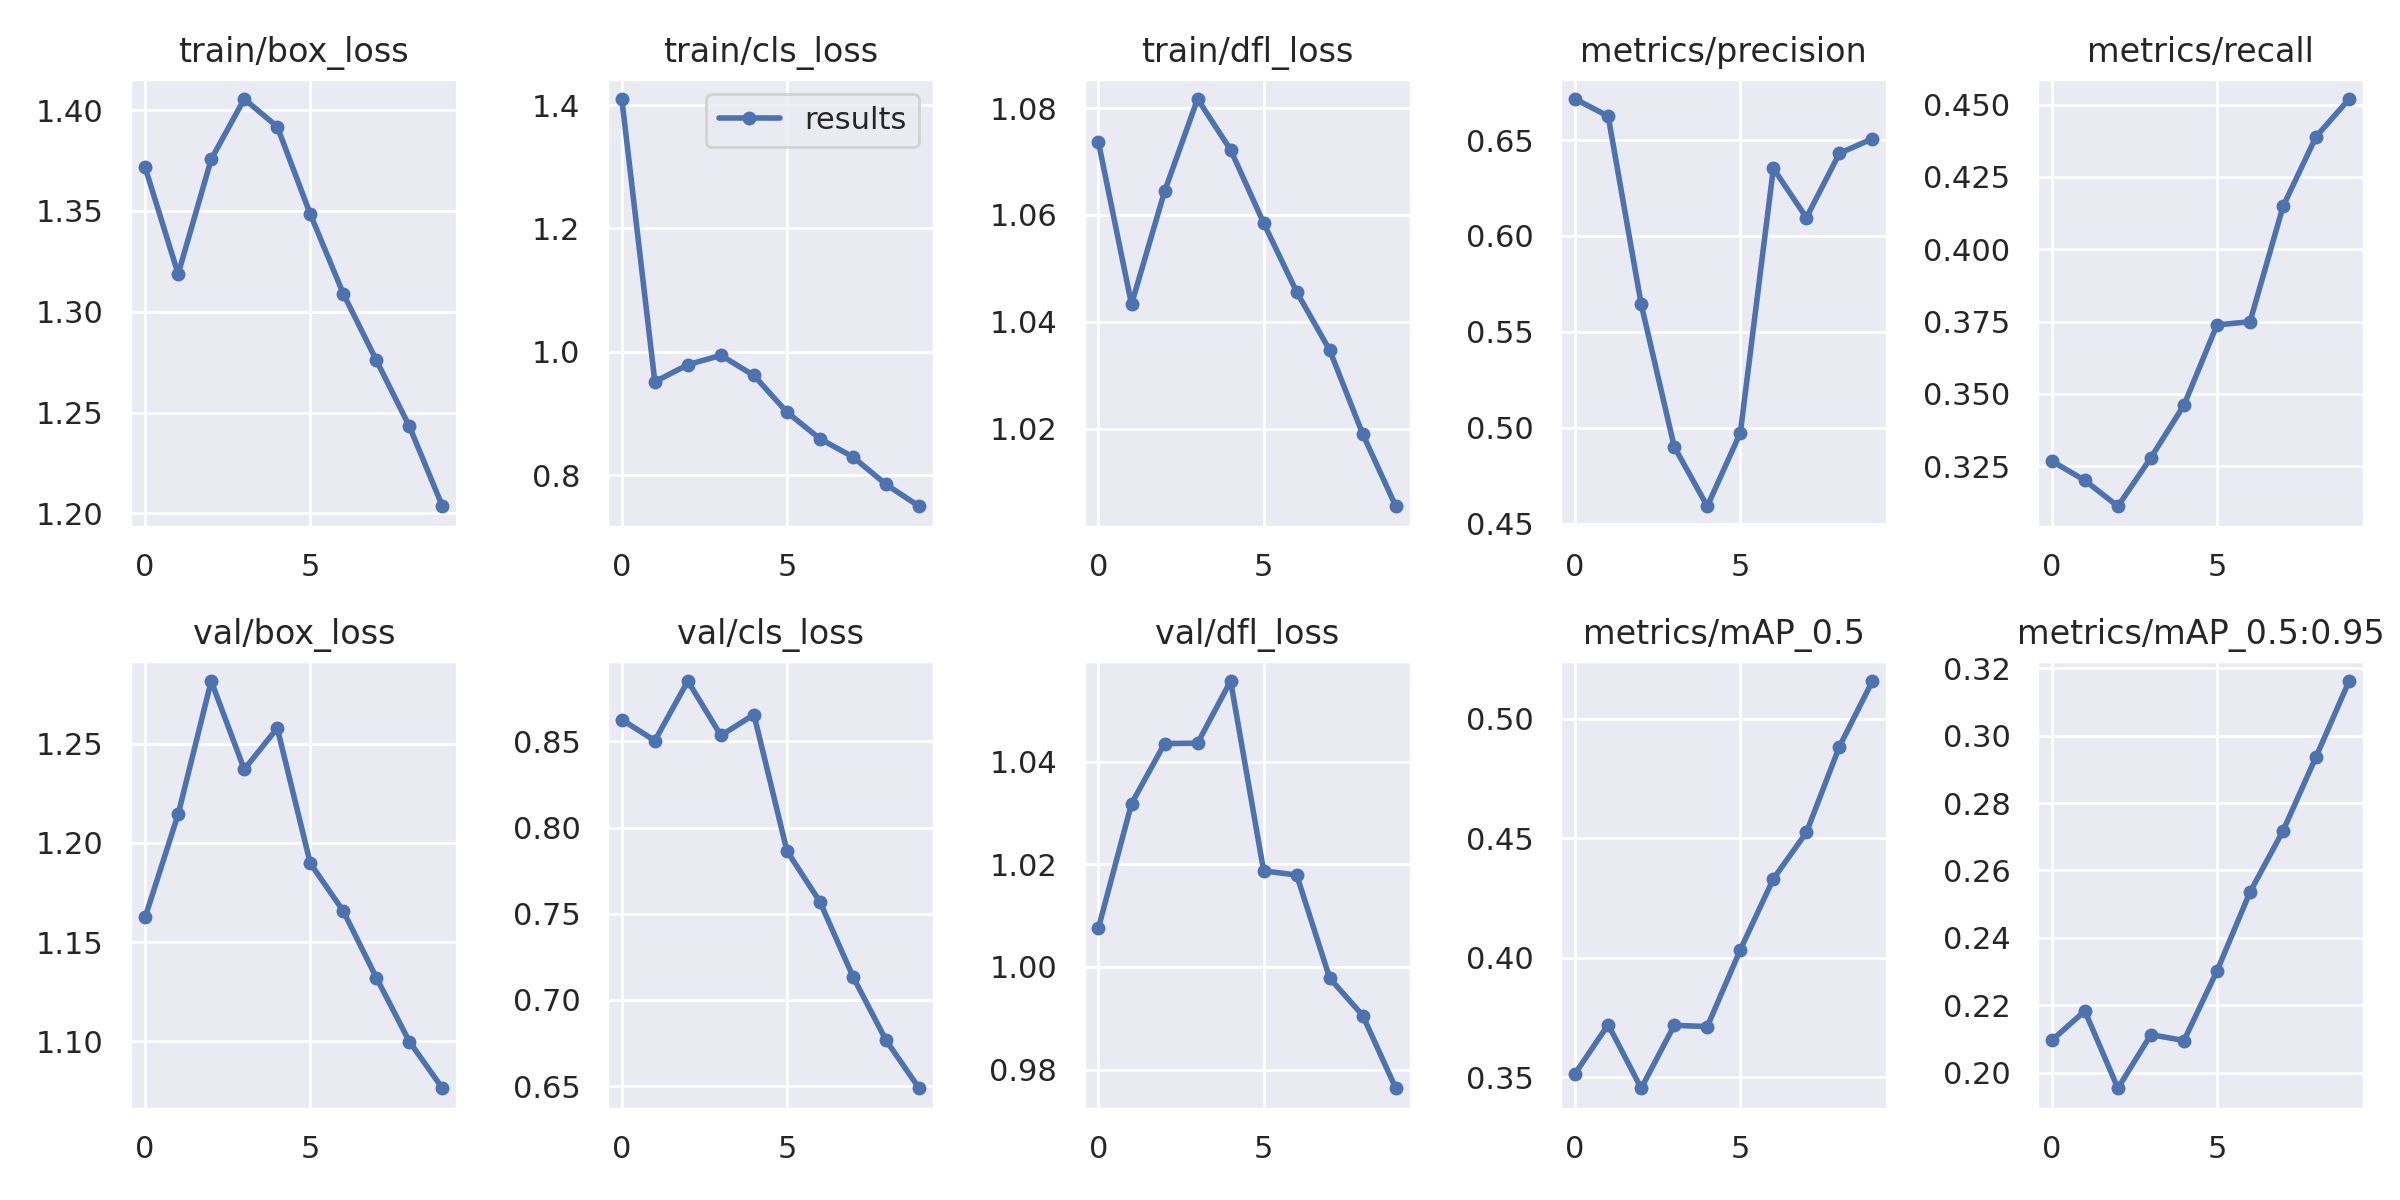

In [5]:
from IPython.display import Image
Image(filename=f"{HOME}/yolov9/runs/train/exp/results.png", width=1000)

### Wyświetlamy wyniki na zbiorze uczącycm

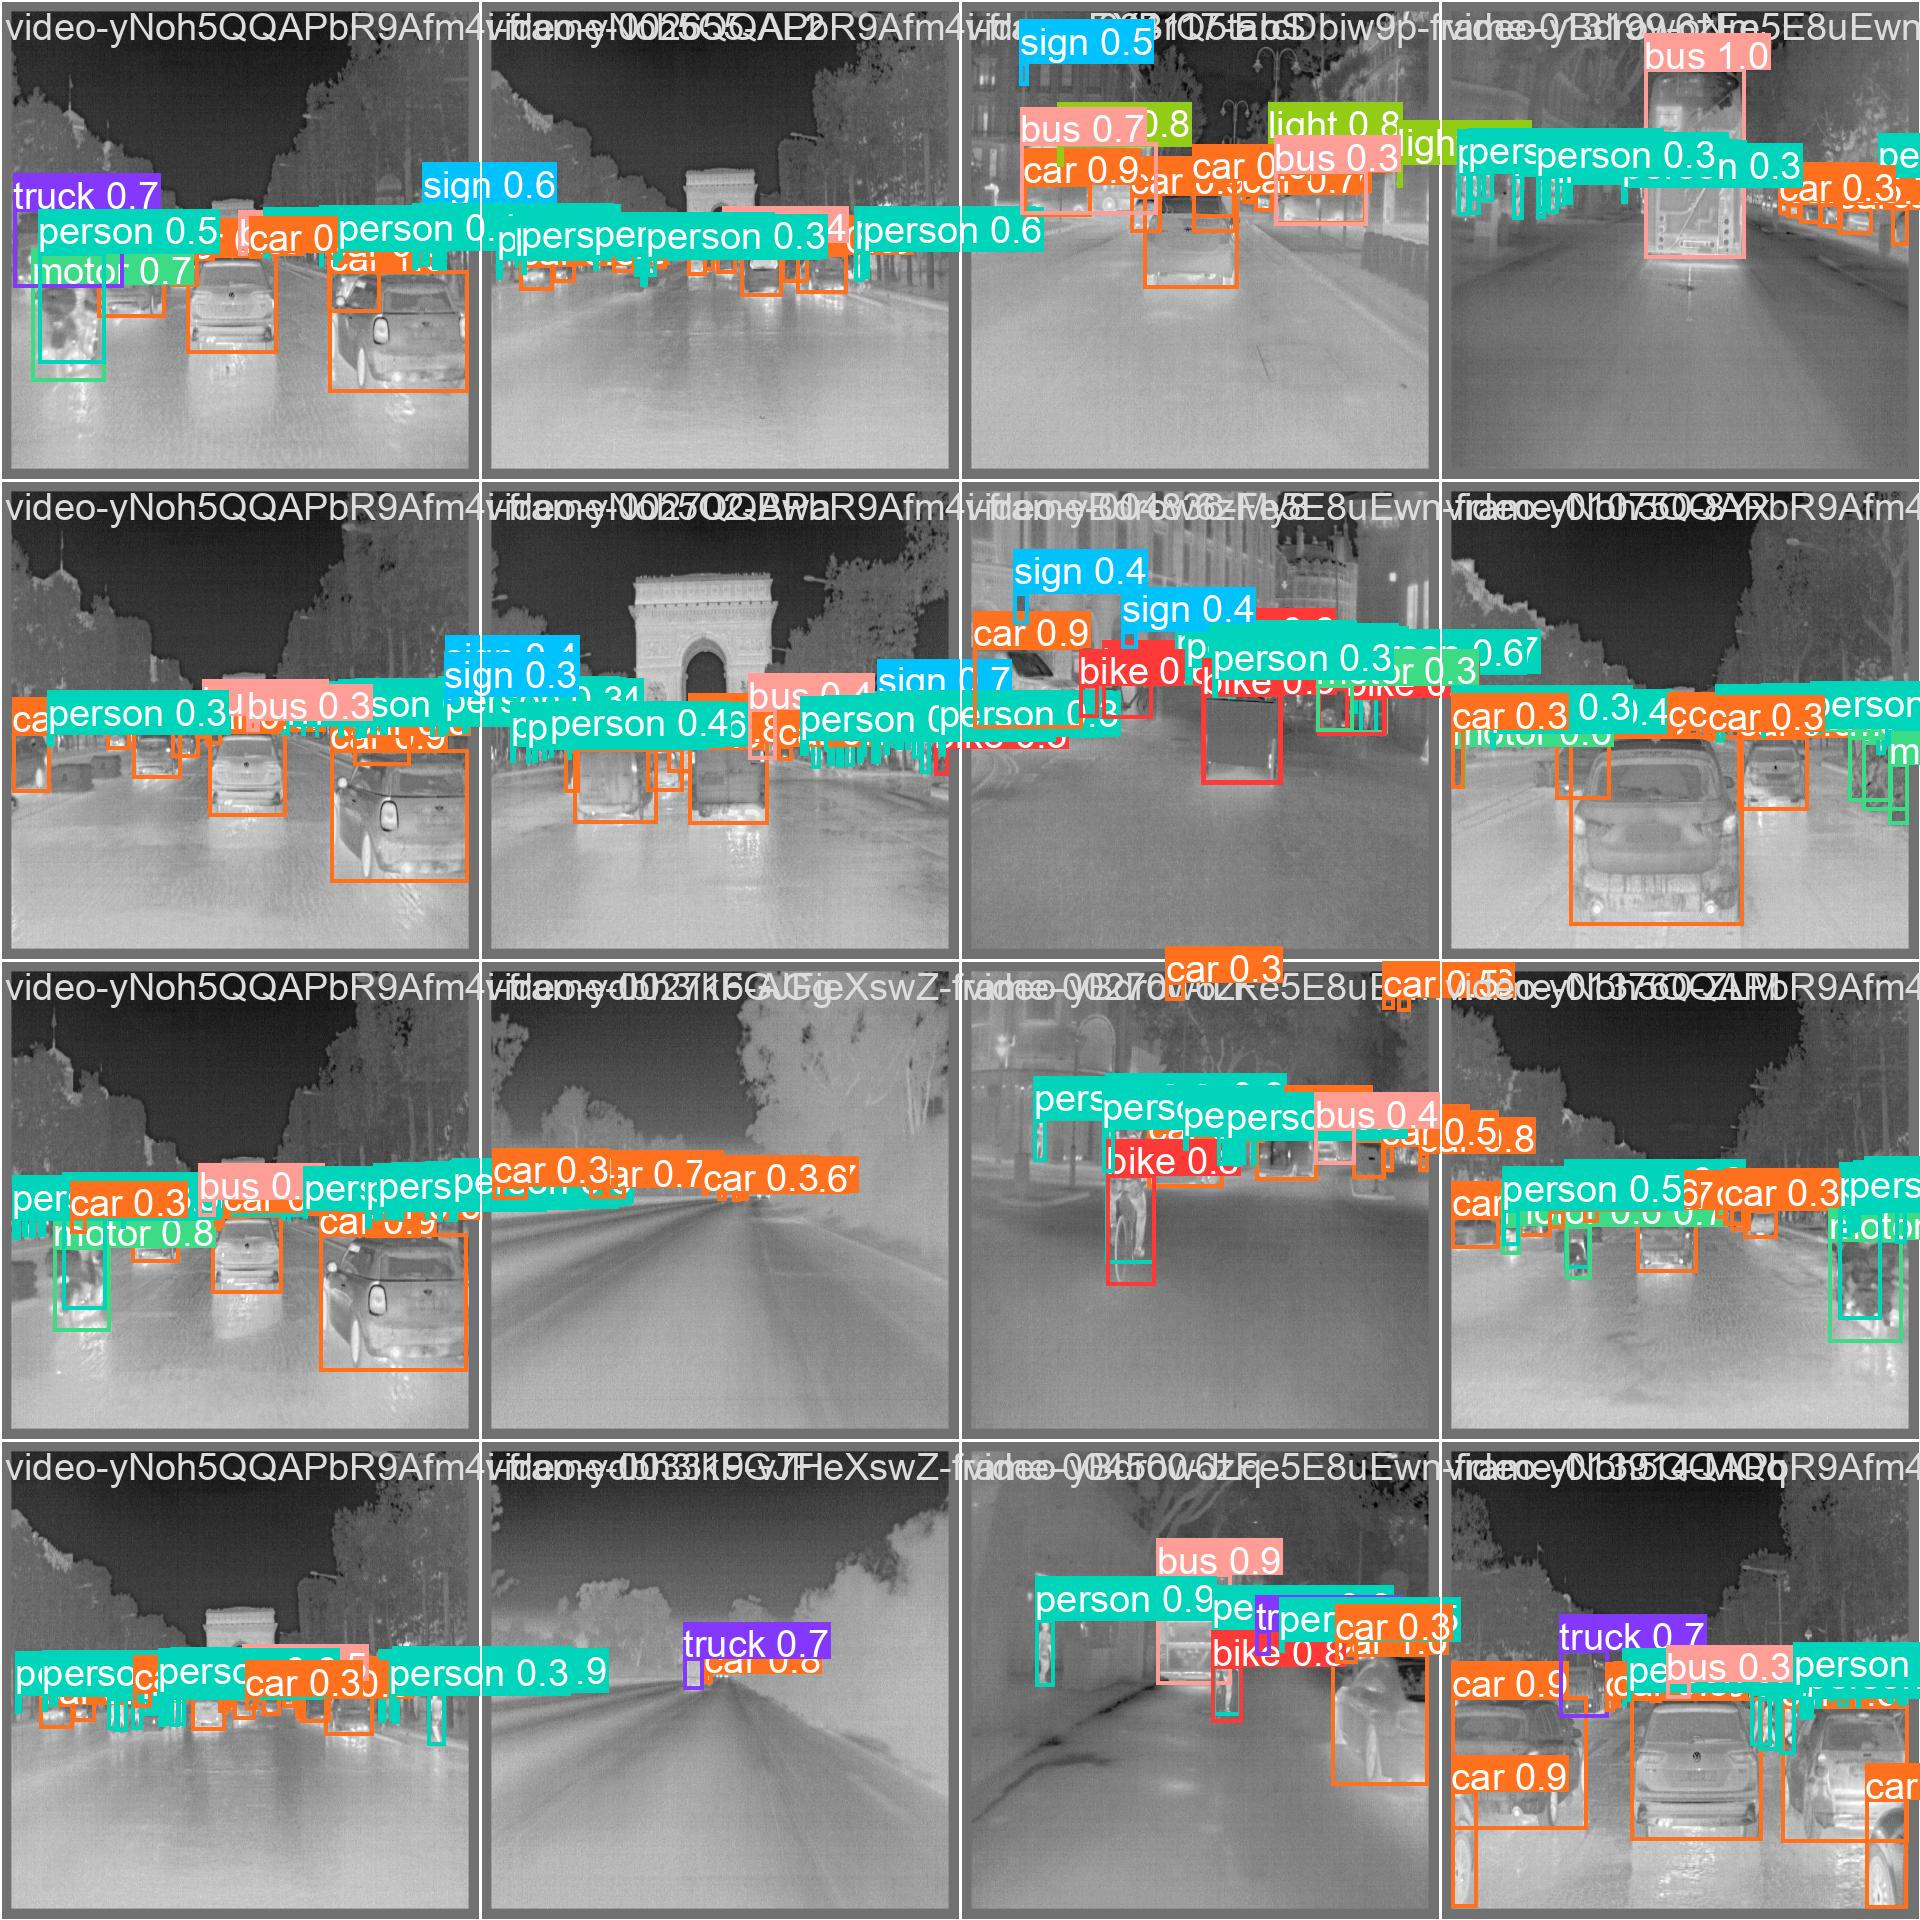

In [6]:
Image(filename=f"{HOME}/yolov9/runs/train/exp/val_batch0_pred.jpg", width=1000)

## Macierz błędów dla zbioru uczącego

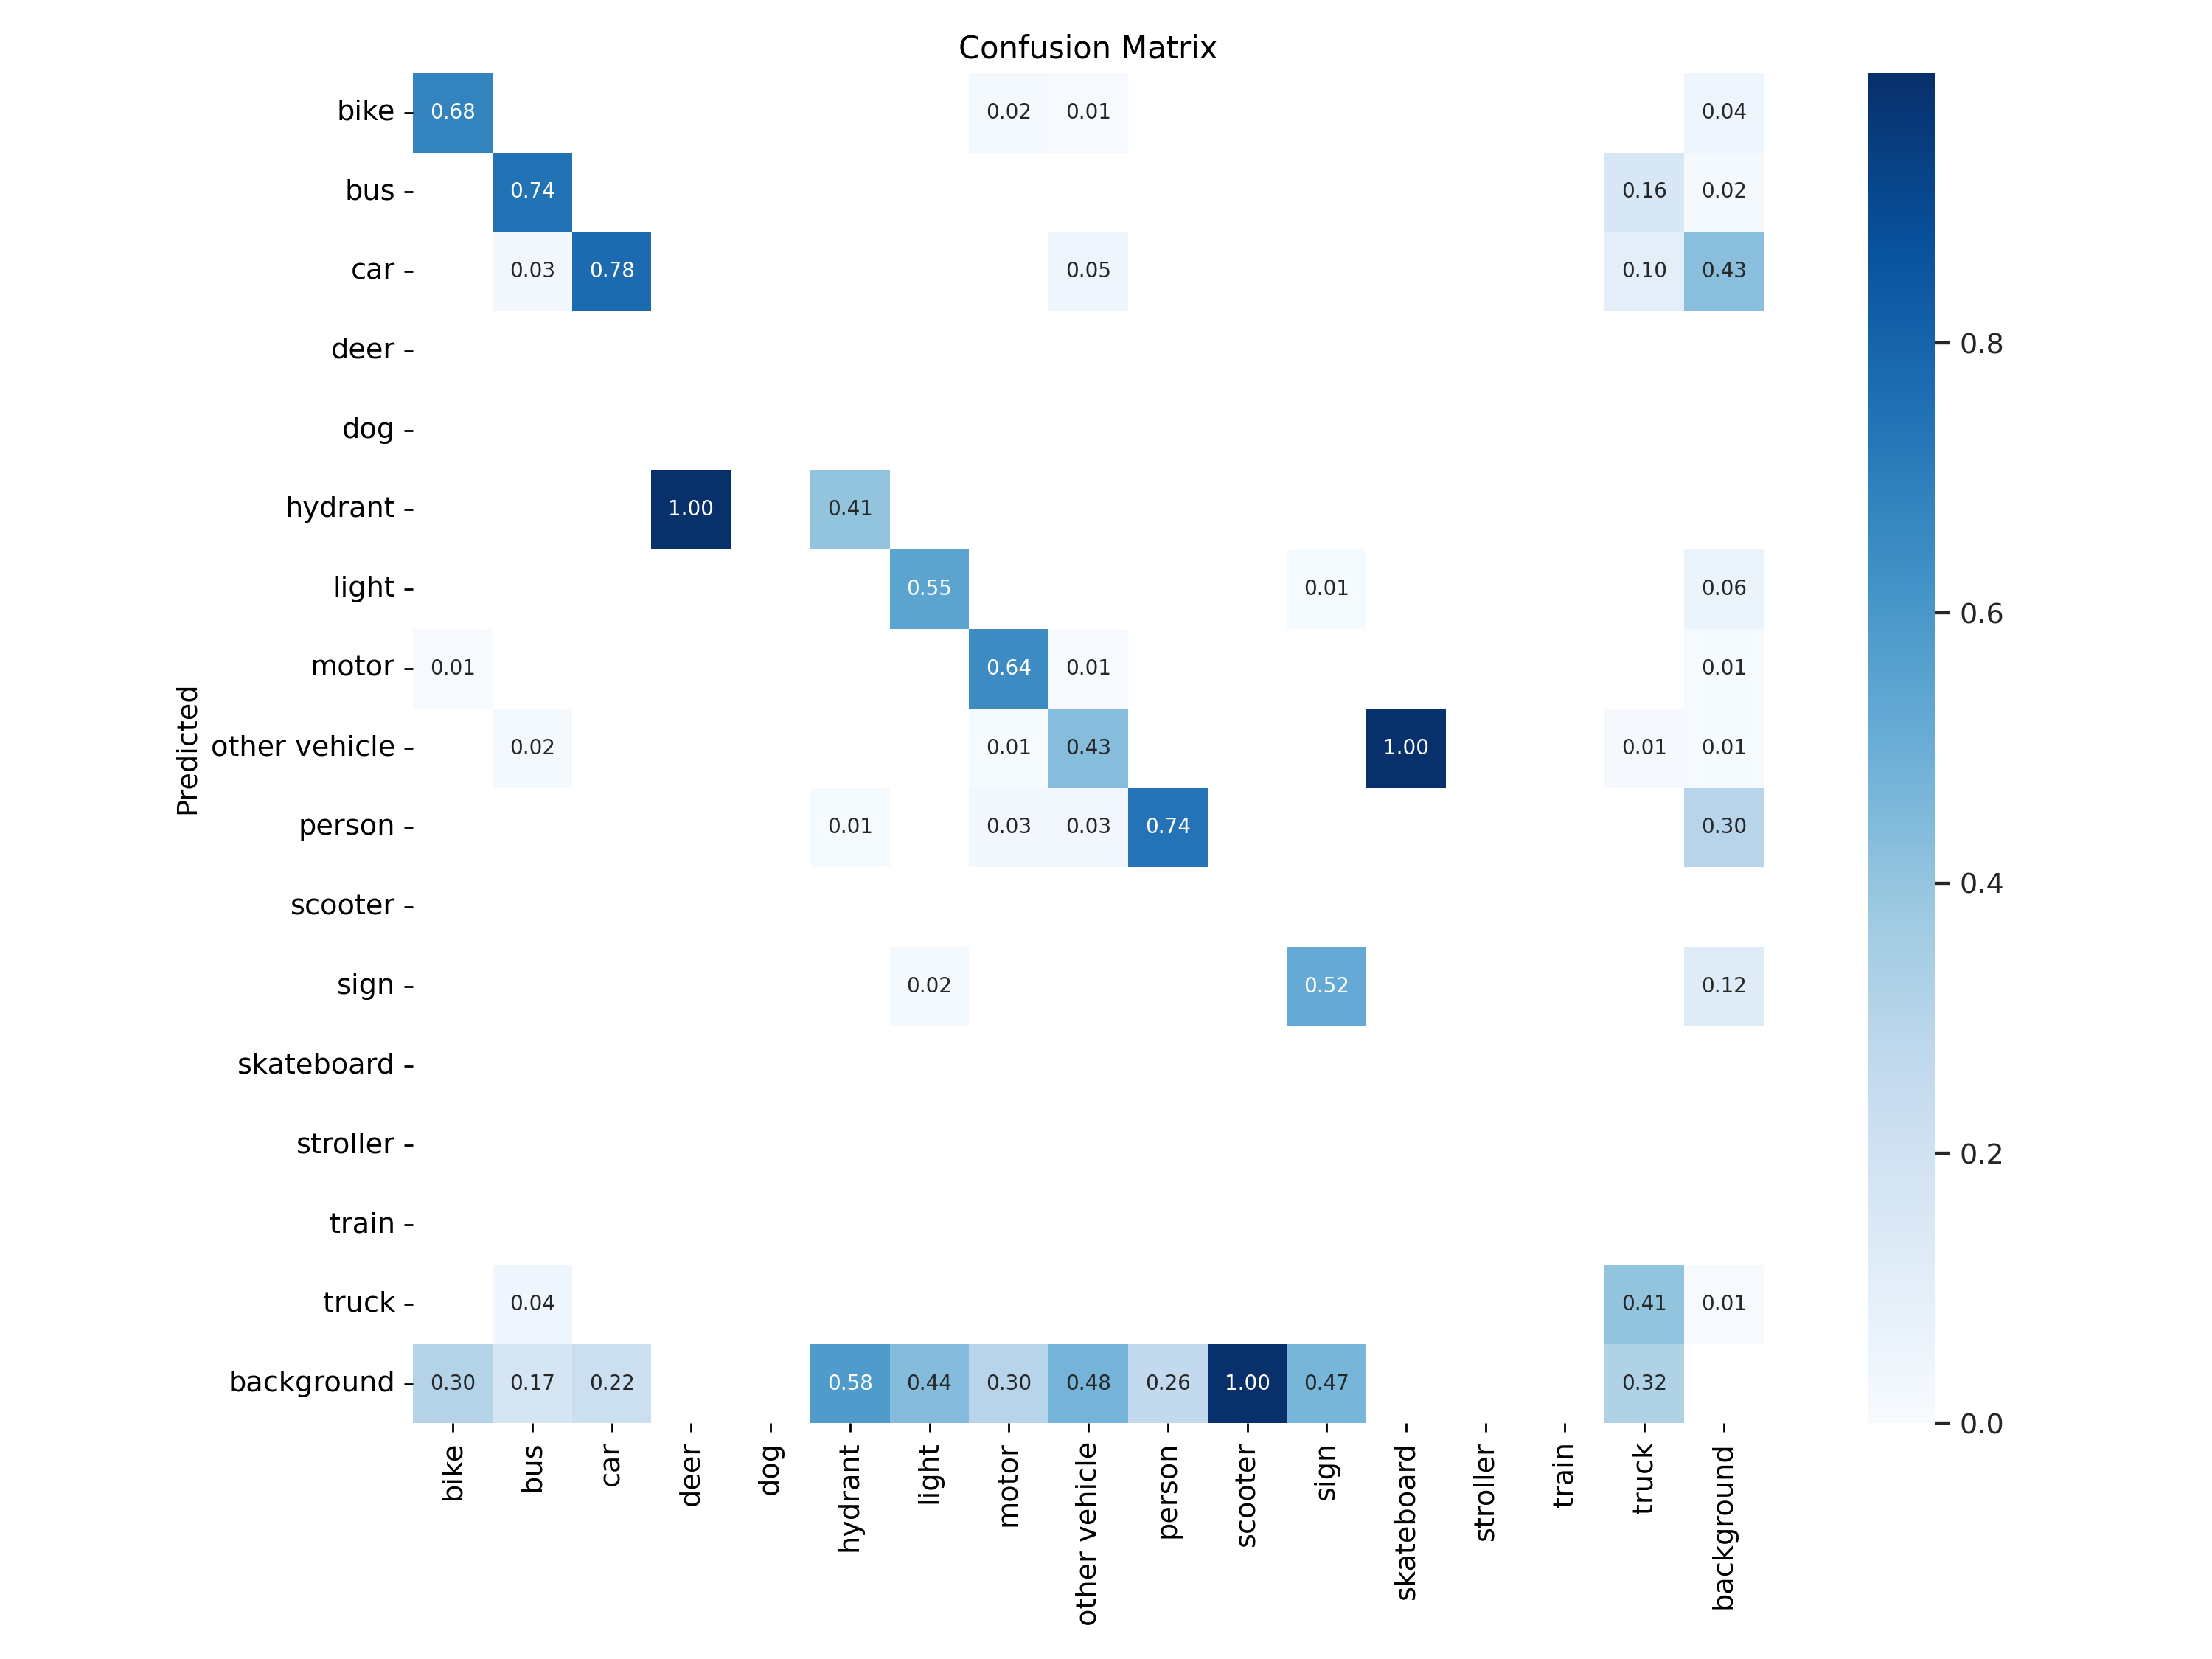

In [7]:
Image(filename=f"{HOME}/yolov9/runs/train/exp/confusion_matrix.png", width=1000)

## Testowanie modelu:

In [16]:
!python detect.py --weights /content/yolov9/runs/train/exp/weights/best.pt --conf 0.1 --source {HOME}/data/test_rgb.jpg --device 0 --hide-conf

detect: weights=['/content/yolov9/runs/train/exp/weights/best.pt'], source=/content/data/test_rgb.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=True, half=False, dnn=False, vid_stride=1
YOLO 🚀 v0.1-89-g93f1a28 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)

Fusing layers... 
gelan-c summary: 387 layers, 25239424 parameters, 0 gradients, 101.9 GFLOPs
image 1/1 /content/data/test_rgb.jpg: 544x640 1 bike, 4 cars, 2 other vehicles, 5 persons, 178.0ms
Speed: 0.6ms pre-process, 178.0ms inference, 554.4ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp4


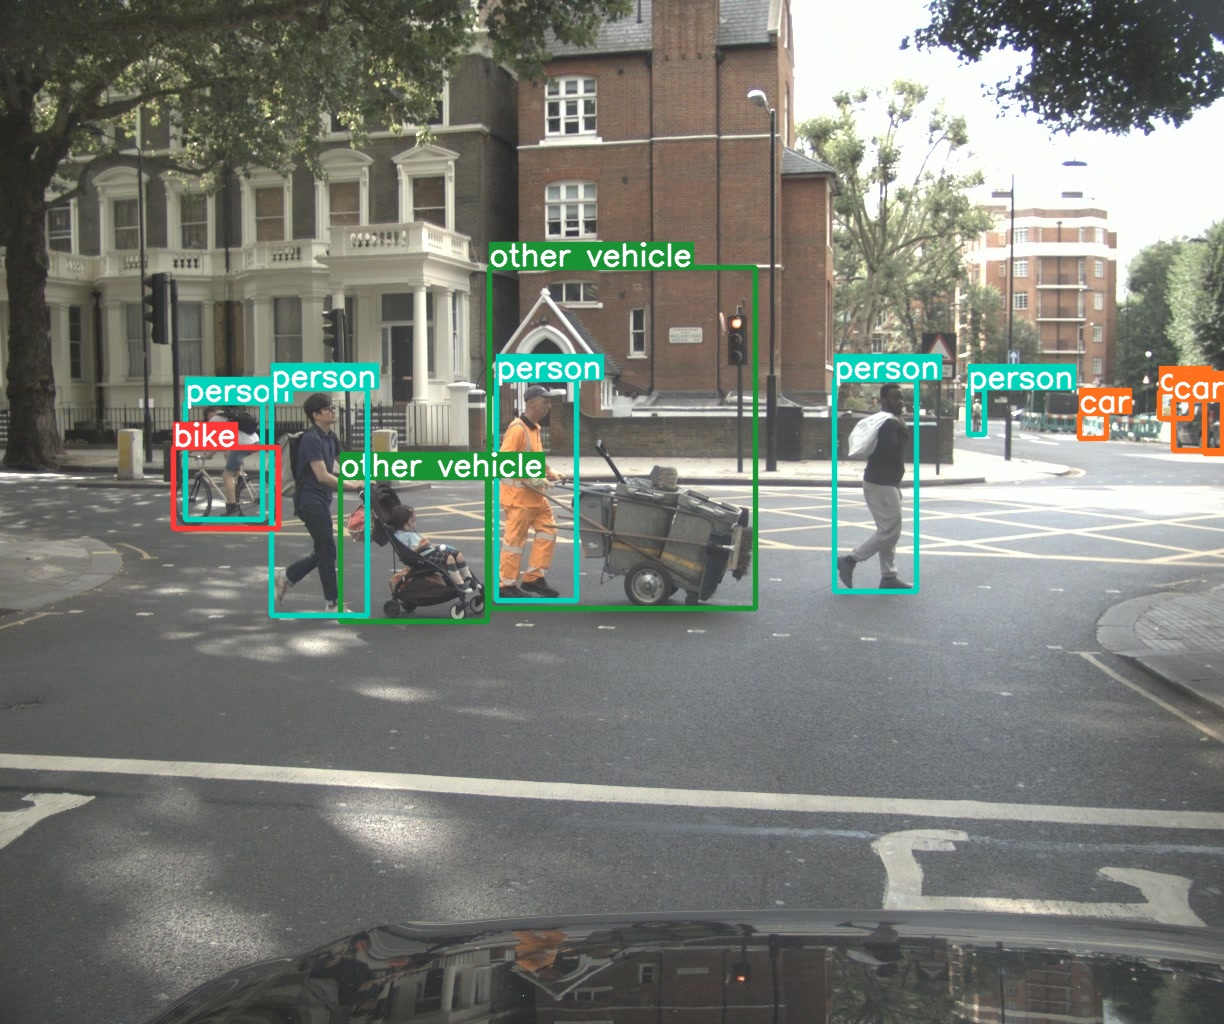

In [17]:
from IPython.display import Image
Image(filename=f"{HOME}/yolov9/runs/detect/exp4/test_rgb.jpg", width=600)

#Przydatne narzędzia


In [ ]:
input_file_path = '/content/drive/MyDrive/ob_thermal_camera/data set/images_thermal_train/coco.json'
output_file_path = '/content/new2.json'

start_line = 1000
end_line = 50000000

# Licznik linii
current_line = 0

with open(input_file_path, 'r') as infile, open(output_file_path, 'w') as outfile:
    for line in infile:
        current_line += 1
        # Pomijanie linii w zakresie od start_line do end_line
        if current_line < start_line or current_line > end_line:
            outfile.write(line)


In [ ]:
import os
from google.colab import files

def find_file_in_directory(directory, filename):
    # Przechodzi przez wszystkie pliki w podanym katalogu
    for root, dirs, files in os.walk(directory):
        if filename in files:
            # Zwraca pełną ścieżkę do pliku
            return os.path.join(root, filename)
    return None

# Przykładowe użycie
directory = '/content/drive/MyDrive/ob_thermal_camera/data set/images_thermal_train/data'  # Katalog, w którym chcesz szukać
filename = 'video-GzdKTLbkG5F7gAunM-frame-000108-QHZmA4QTZCnzBG3HZ.jpg'  # Nazwa pliku, którego szukasz

file_path = find_file_in_directory(directory, filename)
if file_path:
    print(f"File found: {file_path}")
    # Pobranie pliku na lokalny system
    files.download(file_path)
else:
    print("File not found")


File found: /content/drive/MyDrive/ob_thermal_camera/data set/images_thermal_train/data/video-GzdKTLbkG5F7gAunM-frame-000108-QHZmA4QTZCnzBG3HZ.jpg


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import json

# Otwieranie i ładowanie danych z pliku JSON
with open('/content/drive/MyDrive/ob_thermal_camera/data set/images_thermal_train/coco.json') as f:
    d = json.load(f)

# Modyfikowanie pola "segmentation" w każdej adnotacji
for ann in d["annotations"]:
    ann["segmentation"] = []

# Zapisywanie zmodyfikowanych danych do nowego pliku JSON z wcięciami
with open('/content/drive/MyDrive/ob_thermal_camera/data set/images_thermal_train/coco.json', 'w') as f:
    json.dump(d, f, indent=4)  # Ustawienie wcięć na 4 spacje



In [ ]:
directory = '/content/drive/MyDrive/ob_thermal_camera/data set/images_thermal_train/data'
filename = 'coco.json'  # Nazwa pliku, którego szukasz

file_path = find_file_in_directory(directory, filename)
if file_path:
    print(f"File found: {file_path}")
    # Pobranie pliku na lokalny system
    files.download(file_path)

In [ ]:
%cd /content
!git clone https://github.com/tw-yshuang/coco2yolo.git
%cd coco2yolo
!chmod +x coco2yolo
!pip install pycocotools requests click

/content
fatal: destination path 'coco2yolo' already exists and is not an empty directory.
/content/coco2yolo


In [ ]:
!./coco2yolo -ann-path '/content/drive/MyDrive/AGH/ThermalCameraObjectDetection/data set/images_rgb_train/coco.json'

Enter the directory that you save COCO images: /content/drive/MyDrive/AGH/ThermalCameraObjectDetection/data set/images_rgb_train/data
Enter the directory that you want to save the task: /content/folder1
loading annotations into memory...
Done (t=1.81s)
creating index...
index created!
COCO categories: 
['person', 'bike', 'car', 'motor', 'airplane', 'bus', 'train', 'truck', 'boat', 'light', 'hydrant', 'sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'deer', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phon